# **Proactive Fraud Detection and Prevention in Financial Transactions: A Machine Learning Approach**

**Loading and Exploring a Fraud Dataset using Pandas**

In [ ]:
import pandas as pd
import csv

# Load and preprocess the dataset
cleaned_data = []
with open("Fraud.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) == 11:
            cleaned_data.append(row)

# Convert the cleaned data to a DataFrame
columns = cleaned_data[0]
cleaned_data = cleaned_data[1:]
df = pd.DataFrame(cleaned_data, columns=columns)

# Display the first few rows
print(df.head())

# Check the column names
print(df.columns)

  step      type    amount     nameOrig oldbalanceOrg newbalanceOrig  \
0    1   PAYMENT   9839.64  C1231006815      170136.0      160296.36   
1    1   PAYMENT   1864.28  C1666544295       21249.0       19384.72   
2    1  TRANSFER     181.0  C1305486145         181.0            0.0   
3    1  CASH_OUT     181.0   C840083671         181.0            0.0   
4    1   PAYMENT  11668.14  C2048537720       41554.0       29885.86   

      nameDest oldbalanceDest newbalanceDest isFraud isFlaggedFraud  
0  M1979787155            0.0            0.0       0              0  
1  M2044282225            0.0            0.0       0              0  
2   C553264065            0.0            0.0       1              0  
3    C38997010        21182.0            0.0       1              0  
4  M1230701703            0.0            0.0       0              0  
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
 

**Data Preprocessing and Random Forest Classification for Fraud Detection**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('Fraud.csv')

# Handle missing values
data.dropna(inplace=True)

# Handle outliers
def handle_outliers(df, cols):
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df[col] = df[col].apply(lambda x: max(lower_bound, min(upper_bound, x)))
    return df

numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
data = handle_outliers(data, numerical_cols)

# Feature engineering
data['hour_of_day'] = data['step'] % 24
data['day_of_week'] = (data['step'] // 24) % 7

# Split data into features (X) and target (y)
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

# Verify and convert categorical columns to string
categorical_cols = ['type']
X[categorical_cols] = X[categorical_cols].astype(str)

# Preprocessing pipeline for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing pipeline to training and validation sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Impute missing values in X_train_processed
imputer = SimpleImputer(strategy='mean')
X_train_processed = imputer.fit_transform(X_train_processed)

# Check and handle missing values in target labels
y_train = y_train.fillna(0)

# Build and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_processed, y_train)

# Impute missing values in X_val_processed
X_val_processed = imputer.transform(X_val_processed)

# Evaluate the model
y_pred = model.predict(X_val_processed)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Feature importance
if 'cat' in preprocessor.named_transformers_:
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
    feature_names = numerical_cols + list(cat_feature_names)
else:
    feature_names = numerical_cols

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


[[79129     0]
 [   18    17]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     79129
         1.0       1.00      0.49      0.65        35

    accuracy                           1.00     79164
   macro avg       1.00      0.74      0.83     79164
weighted avg       1.00      1.00      1.00     79164

          Feature  Importance
4  newbalanceDest    0.270668
1   oldbalanceOrg    0.241040
0          amount    0.238677
3  oldbalanceDest    0.185990
2  newbalanceOrig    0.035498
9   type_TRANSFER    0.016094
6   type_CASH_OUT    0.009038
5    type_CASH_IN    0.001693
8    type_PAYMENT    0.001171
7      type_DEBIT    0.000131


**Visualizing Model Performance and Feature Importance for Fraud Detection**

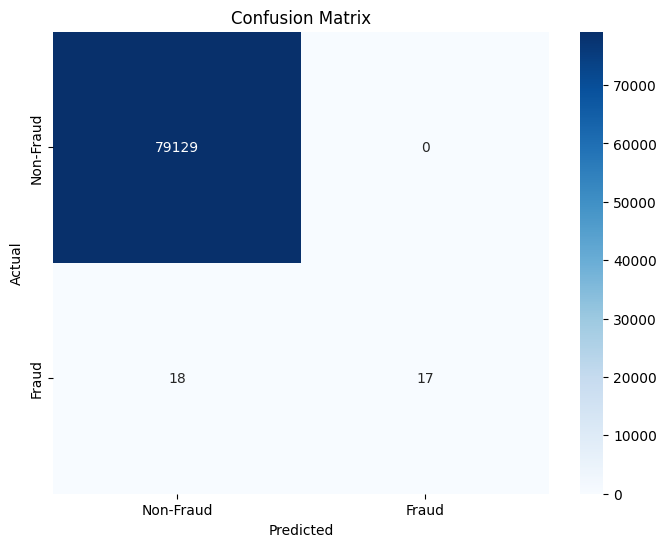

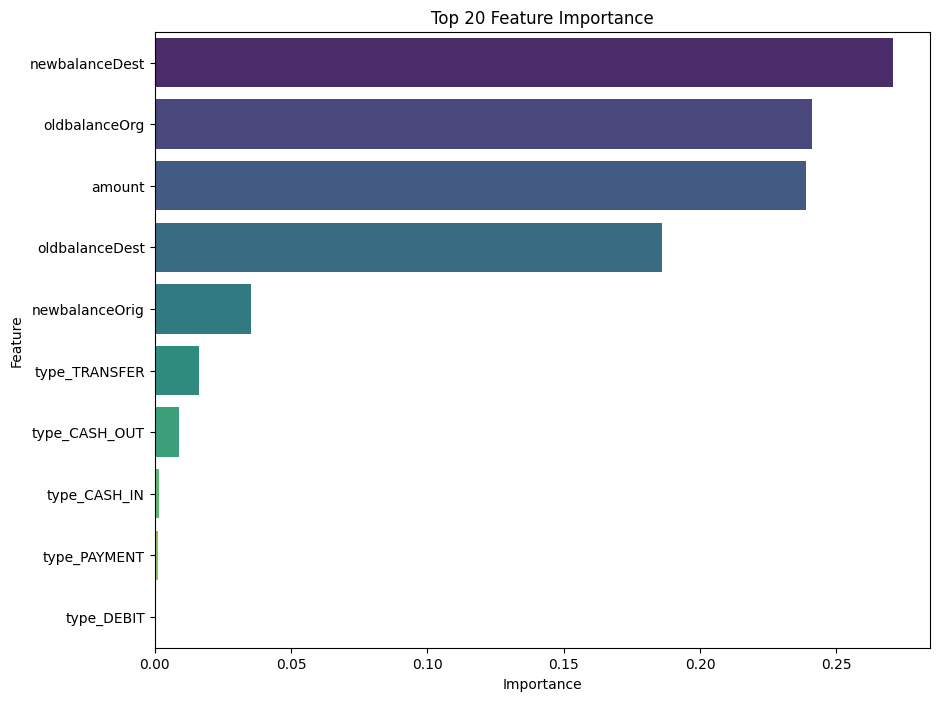

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance[:20], palette='viridis')
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
